In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
np.set_printoptions(precision = 3, suppress = True)

## Частина перша: статистика Дурбина-Уотсона

In [2]:
def DurbinWatson(eps):
    return ((eps[1:] - eps[:-1])**2).sum()/(eps**2).sum()

In [3]:
dw_test = np.loadtxt('./lab3_data/example_for_DW.txt')

In [4]:
DurbinWatson(dw_test)

1.2288100804239723

## Частина друга: побудова адекватного рівняння для опису процесу

In [5]:
rts1 = pd.read_csv('./lab3_data/rts1.txt', squeeze=True, header=None, names=['rts1'])
rts1996 = pd.read_csv('./lab3_data/1996rts1.txt', squeeze=True, header=None, names=['1996rts1'])

Описові характеристики та гістрограма

In [6]:
from scipy.stats import jarque_bera

def DescrStats(series):
    return pd.Series({
        'Mean': series.mean(),
        'Median': series.median(),
        'Maximum': series.max(),
        'Minimum': series.min(),
        'Std. Dev.': series.std(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurt(),
        'Jarque-Bera': jarque_bera(series).statistic,
        'Probability': jarque_bera(series).pvalue
    })

Mean           2.043537e+03
Median         2.068170e+03
Maximum        2.487920e+03
Minimum        1.058840e+03
Std. Dev.      2.899214e+02
Skewness      -1.082895e+00
Kurtosis       1.442272e+00
Jarque-Bera    4.809477e+01
Probability    3.600420e-11
dtype: float64


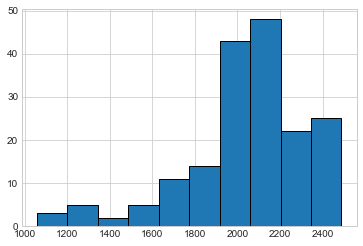

In [7]:
print(DescrStats(rts1))
plt.hist(rts1, facecolor='tab:blue', edgecolor='black')
plt.show()

Mean           1.421474e+02
Median         1.631500e+02
Maximum        2.277900e+02
Minimum        6.669000e+01
Std. Dev.      4.697269e+01
Skewness      -3.605442e-01
Kurtosis      -1.473238e+00
Jarque-Bera    2.768269e+01
Probability    9.744982e-07
dtype: float64


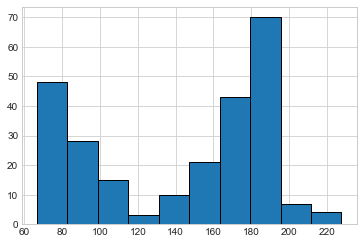

In [8]:
print(DescrStats(rts1996))
plt.hist(rts1996, facecolor='tab:blue', edgecolor='black')
plt.show()

Реалізація АКФ та ЧАКФ (з ЛР №2)

In [29]:
def ACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    return np.array([((data - data.mean()) * (data.shift(s) - data.mean())).sum()
            / ((data.size - 1) * data.var())
            for s in range(1, data.size+1)][:N])

def PACF(data, maxlag=None):
    N = maxlag if maxlag else data.size
    r = ACF(data)
    phi = np.zeros((N, N))
    phi[0, 0] = r[0]   
    for k in range(1, N):
        sum_top = sum([phi[k-1, j]*r[k-1-j] for j in range (0, k)])
        sum_bottom = sum([phi[k-1, j]*r[j] for j in range (0, k)])
        phi[k, k] = (r[k] - sum_top) / (1 - sum_bottom)
        for j in range(0, k):
            phi[k, j] = phi[k-1, j] - phi[k, k]*phi[k-1, k-1-j]
            phi[j, k] = phi[k, j]      
    return np.diag(phi)

def SMA(data, N):
    sma = data.rolling(N).mean()
    sma.name += f' SMA (N={N})'
    return sma

def EMA(data, N, return_weights=False):
    a = 2 / (N + 1)
    w = [(1 - a)**n for n in range(N, 0, -1)]
    ema = data.rolling(N).apply(lambda window: (w * window).sum() / sum(w))
    ema.name += f' EMA (N={N})'
    return (ema, w) if return_weights else ema

In [231]:
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def r_squared(y_true, y_pred):
    return y_pred.var()/y_true.var()

def log_likelihood(y_true, y_pred):
    N = len(y_pred)
    return -N/2*(np.log(2*np.pi) + np.log(sum_squared_error(y_true, y_pred)/N))

def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + 2*n/N

def schwarz(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] + 1
    N = y_true.size 
    return -2*log_likelihood(y_true, y_pred)/N + n*np.log(N)/N

def ModelEstimation(y_true, y_pred, ARMA):
    N = len(y_pred)
    n = ARMA[0] + ARMA[1] + 1
    return pd.Series({
        'R-squared': r_squared(y_true, y_pred),
        'Adjusted R-squared': 1 - (1-r_squared(y_true, y_pred))*((N-1)/(N-n-1)),
        'S.E. of regression': np.sqrt(sum_squared_error(y_true, y_pred)/N),
        'Sum squared resid': sum_squared_error(y_true, y_pred),
        'Log likelihood': log_likelihood(y_true, y_pred),
        'Durbin-Watson stat': DurbinWatson(y_pred - y_true),
        'Mean dependent var': y_pred.mean(),
        'S.D. dependent var': y_pred.std(),
        'Akaike info criterion': akaike(y_true, y_pred, ARMA),
        'Schwarz criterion': schwarz(y_true, y_pred, ARMA)
    })

In [157]:
def ARMA(y, ma_window, ma_type, pacf_tolerance=0.2, method='residuals'):
    pacf = PACF(y, maxlag=12)
    N = ma_window
    try:
        p = np.where(abs(PACF(rts1, maxlag=12)) >= pacf_tolerance)[0].max()+1
    except ValueError:
        p = 0
    if method == 'residuals':
        Y = np.ones((len(y)-p, p+1))
        for k in range(1, p+1):
            Y[:, k] = y[p-k:-k]
        a_coef = np.linalg.pinv(Y.T @ Y) @ Y.T @ y[p:]
        residuals = y[p:] - Y @ a_coef
        try:
            q = np.where(abs(PACF(residuals, maxlag=12)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            q = 0
        if ma_type == 'sma':
            ma = SMA(residuals, N)[N:]
        elif ma_type == 'ema':
            ma = EMA(residuals, N)[N:]
        else: raise ValueError('unknown Moving Average type') 
        diff = len(y)-len(ma)
        y_trim = y[diff:]
        X = np.ones((len(y_trim)-max(p, q), p+q+1))
        for k in range(1, p+1):
            X[:, k] = y_trim[max(p, q)-k:-k]
        for k in range(1, q+1):
            X[:, p+k] = ma[max(p, q)-k:-k]
        a_coef = np.linalg.pinv(X.T @ X) @ X.T @ (y_trim - ma)[max(p, q):]
        return {'prediction': X @ a_coef + ma[max(p, q):],
                'coefficients': a_coef,
                'model_order': (p, q)}


R-squared                   0.987511
Adjusted R-squared          0.986941
S.E. of regression          4.666967
Sum squared resid        5009.533118
Log likelihood           -565.673012
Durbin-Watson stat          1.875892
Mean dependent var        146.921870
S.D. dependent var         45.310782
Akaike info criterion       5.005852
Schwarz criterion           5.155334
dtype: float64


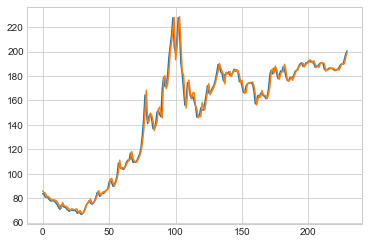

In [248]:
estim = ARMA(rts1996, ma_window=10, ma_type='sma')
start_index = estim['prediction'].index.start
plt.plot(rts1996.values[start_index:])
plt.plot(estim['prediction'].values)
print(ModelEstimation(rts1996[start_index:].values, estim['prediction'].values, estim['model_order']))